In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner')
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Pre process the labels

In [4]:
target = train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
train.drop('surface', axis=1, inplace=True)

### Train/validation split

In [5]:
features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id', 'measurement_number']

X_train, X_val, Y_train, Y_val = train_test_split(train[features], target, test_size=0.2, random_state=0)

### Feature engineering

In [6]:
def agg_features(df):
#     df['orientation'] = df['orientation_X'] + df['orientation_Y'] + df['orientation_Z'] + df['orientation_W']
    df['angular_velocity'] = df['angular_velocity_X'] + df['angular_velocity_Y'] + df['angular_velocity_Z']
    df['linear_acceleration'] = df['linear_acceleration_X'] + df['linear_acceleration_Y'] + df['linear_acceleration_Z']
    
agg_features(X_train)
agg_features(X_val)
agg_features(test)

### Mean encoding on categorical features

In [7]:
features.append('angular_velocity')
features.append('linear_acceleration')
mean_enc_features = list(features)

# By series
for feature in (features):
    if feature not in ['series_id', 'measurement_number']:
        median = '%s_series_mean' % feature
        std = '%s_series_std' % feature
        diff = '%s_series_mean_diff' % feature
        mean_enc_features.append(median)
        mean_enc_features.append(std)
        mean_enc_features.append(diff)
        X_train[median] = X_train['series_id'].map(X_train.groupby('series_id')[feature].mean())
        X_val[median] = X_val['series_id'].map(X_val.groupby('series_id')[feature].mean())
        test[median] = test['series_id'].map(test.groupby('series_id')[feature].mean())
        
        X_train[std] = X_train['series_id'].map(X_train.groupby('series_id')[feature].std())
        X_val[std] = X_val['series_id'].map(X_val.groupby('series_id')[feature].std())
        test[std] = test['series_id'].map(test.groupby('series_id')[feature].std())
        
        X_train[diff] = X_train[feature] - X_train[median]
        X_val[diff] = X_val[feature] - X_val[median]
        test[diff] = test[feature] - test[median]
    

# By measurement
for feature in (features):
    if feature not in ['series_id', 'measurement_number']:
        median = '%s_measurement_mean' % feature
        std = '%s_measurement_std' % feature
        diff = '%s_measurement_mean_diff' % feature
        mean_enc_features.append(median)
        mean_enc_features.append(std)
        mean_enc_features.append(diff)
        X_train[median] = X_train['measurement_number'].map(X_train.groupby('measurement_number')[feature].mean())
        X_val[median] = X_val['measurement_number'].map(X_val.groupby('measurement_number')[feature].mean())
        test[median] = test['measurement_number'].map(test.groupby('measurement_number')[feature].mean())
        
        X_train[std] = X_train['measurement_number'].map(X_train.groupby('measurement_number')[feature].std())
        X_val[std] = X_val['measurement_number'].map(X_val.groupby('measurement_number')[feature].std())
        test[std] = test['measurement_number'].map(test.groupby('measurement_number')[feature].std())
        
        X_train[diff] = X_train[feature] - X_train[median]
        X_val[diff] = X_val[feature] - X_val[median]
        test[diff] = test[feature] - test[median]
    
features = list(mean_enc_features)

In [8]:
X_train.drop(['series_id', 'measurement_number'], axis=1, inplace=True)
X_val.drop(['series_id', 'measurement_number'], axis=1, inplace=True)

features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (390144, 56)
Validation shape (97536, 56)


,count,mean,std,min,25%,50%,75%,max
angular_velocity_X,390144.0,7.433775e-05,0.117635,-2.014300,-0.040834,0.000031,0.040461,2.282200
angular_velocity_Y,390144.0,8.340972e-03,0.088679,-0.927860,-0.033167,0.005396,0.048102,1.079100
angular_velocity_Z,390144.0,-1.913315e-02,0.229197,-1.268800,-0.090595,-0.005198,0.064889,1.272500
linear_acceleration_X,390144.0,1.288680e-01,1.868369,-31.142000,-0.530402,0.124245,0.791650,36.797000
linear_acceleration_Y,390144.0,2.887287e+00,2.147481,-121.490000,1.959000,2.880700,3.799325,73.008000
linear_acceleration_Z,390144.0,-9.363993e+00,2.840265,-75.386000,-10.192000,-9.364300,-8.523200,55.766000
angular_velocity,390144.0,-1.071784e-02,0.201563,-2.505400,-0.100577,-0.003816,0.082703,3.073330
linear_acceleration,390144.0,-6.347838e+00,4.629051,-183.983100,-8.011800,-6.357683,-4.677408,122.698700
angular_velocity_X_series_mean,390144.0,7.433775e-05,0.011578,-0.118978,-0.005264,0.000075,0.005313,0.192636
angular_velocity_X_series_std,390144.0,9.047833e-02,0.075186,0.002551,0.034979,0.070219,0.128335,0.808108


### Scale the data

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test[features])

### Model

In [10]:
epochs = 100
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [11]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               7296      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 16,137
Trainable params: 16,137
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, verbose=2)

Train on 390144 samples, validate on 97536 samples
Epoch 1/100
 - 40s - loss: 1.5933 - val_loss: 1.4301
Epoch 2/100
 - 38s - loss: 1.4732 - val_loss: 1.3871
Epoch 3/100
 - 40s - loss: 1.4460 - val_loss: 1.3892
Epoch 4/100
 - 39s - loss: 1.4325 - val_loss: 1.3554
Epoch 5/100
 - 39s - loss: 1.4234 - val_loss: 1.3644
Epoch 6/100
 - 38s - loss: 1.4151 - val_loss: 1.3793
Epoch 7/100
 - 39s - loss: 1.4093 - val_loss: 1.3529
Epoch 8/100
 - 38s - loss: 1.4035 - val_loss: 1.3327
Epoch 9/100
 - 39s - loss: 1.3999 - val_loss: 1.3301
Epoch 10/100
 - 38s - loss: 1.3950 - val_loss: 1.3294
Epoch 11/100
 - 40s - loss: 1.3935 - val_loss: 1.3295
Epoch 12/100
 - 38s - loss: 1.3912 - val_loss: 1.3337
Epoch 13/100
 - 39s - loss: 1.3888 - val_loss: 1.3301
Epoch 14/100
 - 38s - loss: 1.3893 - val_loss: 1.3212
Epoch 15/100
 - 39s - loss: 1.3855 - val_loss: 1.3269
Epoch 16/100
 - 38s - loss: 1.3848 - val_loss: 1.3306
Epoch 17/100
 - 39s - loss: 1.3826 - val_loss: 1.3177
Epoch 18/100
 - 38s - loss: 1.3801 - val

#### Model loss plot

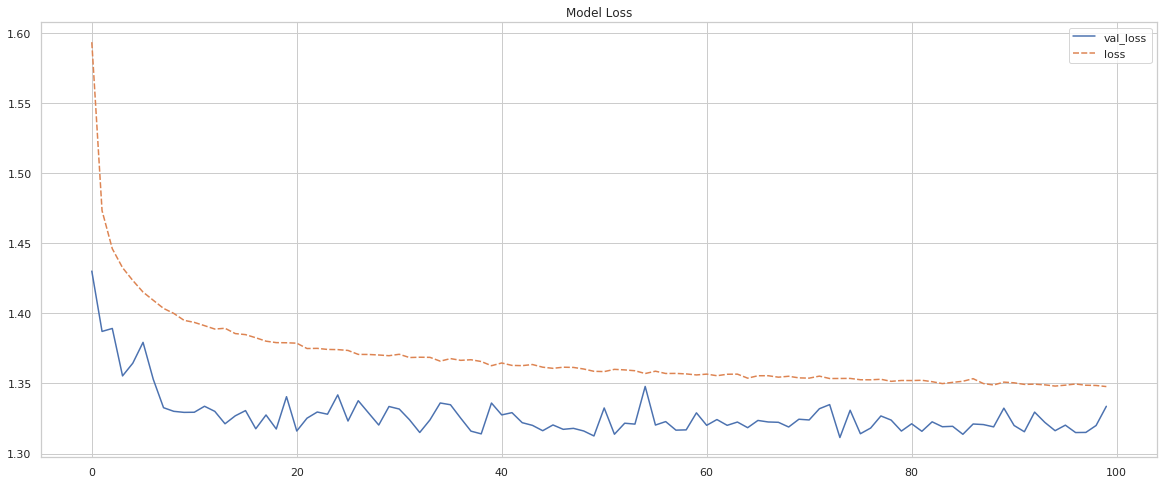

In [13]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [14]:
train_pred = model.predict_classes(X_train)
val_pred = model.predict_classes(X_val)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.541133530183727
Validation accuracy 0.5170706200787402


#### Model confusion matrix

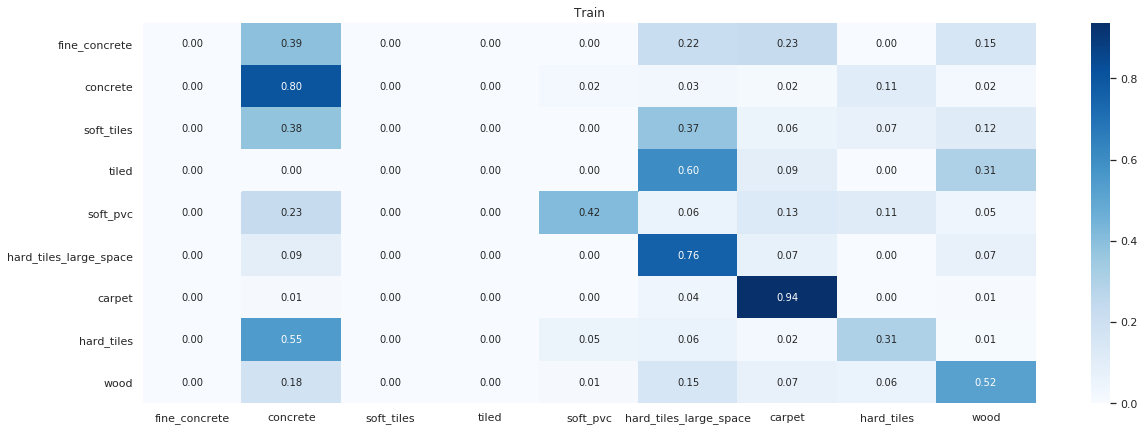

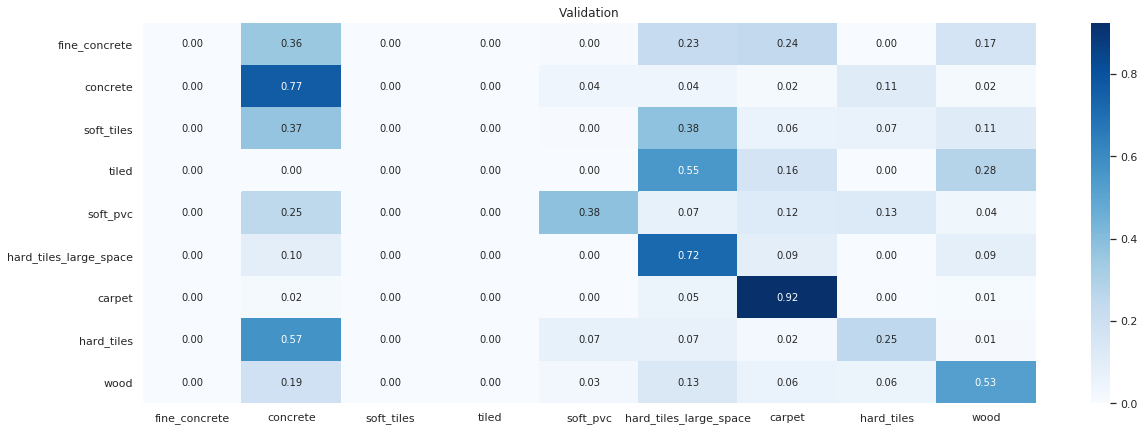

In [15]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [ ]:
predictions = model.predict_classes(X_test)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)